## <b>EDA Process </b>

Load the dataset and explore

In [1]:
import os
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import torch
from scipy import signal
import numpy as np
import heartpy.filtering

In [2]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [3]:
data_files

['mit-bih-normal-sinus-rhythm-database-1.0.0/16265.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16272.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16273.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16420.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16483.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16539.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16773.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16786.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16795.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17052.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17453.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18177.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18184.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19088.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19090.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19093.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19140.dat',
 'mit-bih-normal-sinus-rhythm-d

MIT-BIH Normal Sinus Rhythm (NSR) database. The subjects included in this database were found to have no significant arrhythmias. This dataset comprises 18 long-term ECG recordings, each lasting approximately 24 h and sampled at 128 Hz, of subjects referred to the Arrhythmia Laboratory at Boston’s Beth Israel Hospital (now the Beth Israel Deaconess Medical Centre). It includes 5 men aged 26 to 45 and 13 women aged 20 to 50.

https://physionet.org/content/nsrdb/1.0.0/

In [4]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []

counters = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0,
            16: 0, 17: 0}

In [5]:
## Loop ecg.bin files
part = 0
for participant, file in enumerate(data_files):
    counter = 0

    if participant == part:
        #Get signal
        data = pd.DataFrame({"ECG":wfdb.rdsamp(file[:-4])[0][:,0]})
        data["Participant"] = "MIT-Normal_%.2i" %(participant)
        data["Sample"] = range(len(data))
        data["Sampling_Rate"] = 128
        data["Database"] = "MIT-Normal"

data.head()
    

,ECG,Participant,Sample,Sampling_Rate,Database
0,-0.165,MIT-Normal_00,0,128,MIT-Normal
1,-0.155,MIT-Normal_00,1,128,MIT-Normal
2,-0.195,MIT-Normal_00,2,128,MIT-Normal
3,-0.205,MIT-Normal_00,3,128,MIT-Normal
4,-0.185,MIT-Normal_00,4,128,MIT-Normal


In [6]:
data = data["ECG"].values

In [7]:
ECG_SIGNAL = torch.Tensor(data)
window_complete = ECG_SIGNAL[0:win*fs]

### <b>Data Preprocessing. </b>

Apply both median and bandpass filters to the signals. Specifically, the median filter has a kernel size of 3, and the frequency range of the bandpass filter is between 0.5Hz and 30Hz.

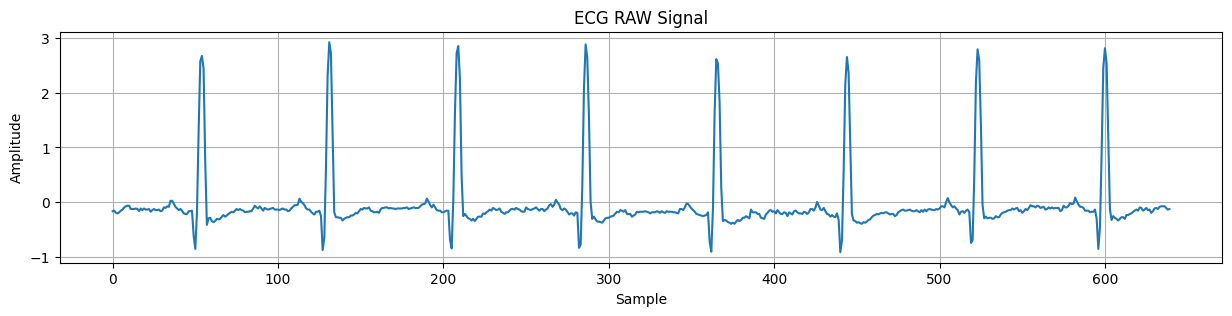

In [8]:
#Plot the signal
plt.figure(figsize=(15, 3))
plt.plot(window_complete)
plt.title("ECG RAW Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

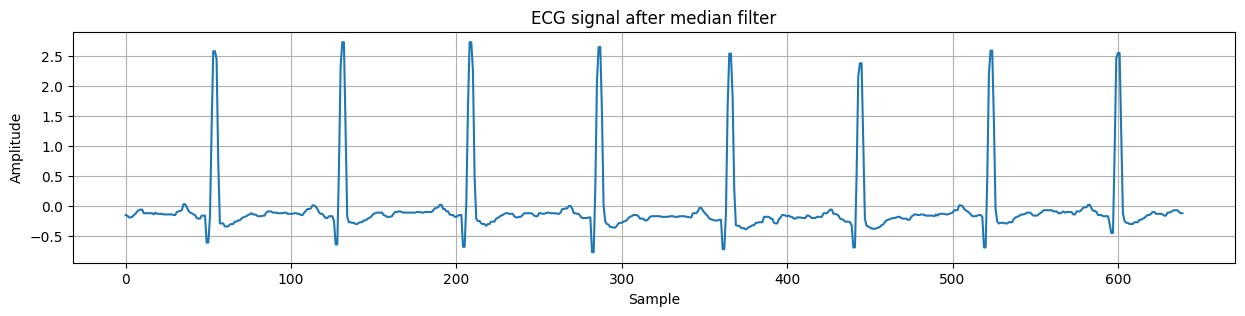

In [9]:
med = signal.medfilt(window_complete, 3)

plt.figure(figsize=(15, 3))
plt.plot(med)
plt.title("ECG signal after median filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

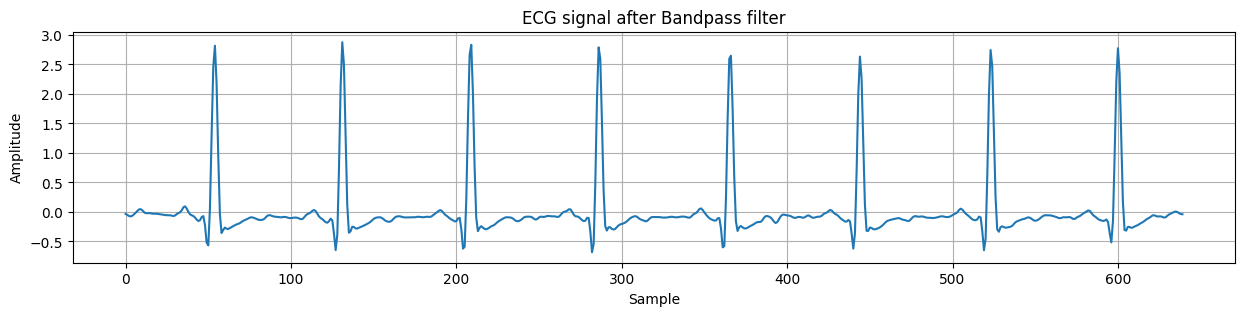

In [10]:
filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                           filtertype='bandpass')

plt.figure(figsize=(15, 3))
plt.plot(filt)
plt.title("ECG signal after Bandpass filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### `biosppy.signals.ecg.ecg` Function

Processes a raw ECG signal and extracts relevant features using default parameters.

**Parameters:**

- **signal** (`array`):  
    Raw ECG signal.

- **sampling_rate** (`int` or `float`, optional, default=1000.0):  
    Sampling frequency in Hz.

- **units** (`str`, optional):  
    Units of the input signal. If specified, the plot's y-axis will be labeled accordingly.

- **path** (`str`, optional):  
    If provided, the plot will be saved to this file path.

- **show** (`bool`, optional, default=True):  
    If `True`, displays a summary plot.

- **interactive** (`bool`, optional, default=False):  
    If `True`, shows an interactive plot.

**Returns:**

- **ts** (`array`):  
    Signal time axis reference (seconds).

- **filtered** (`array`):  
    Filtered ECG signal.

- **rpeaks** (`array`):  
    Indices of detected R-peaks.

- **templates_ts** (`array`):  
    Time axis reference for heartbeat templates (seconds).

- **templates** (`array`):  
    Extracted heartbeat templates.

- **heart_rate_ts** (`array`):  
    Time axis reference for heart rate (seconds).

- **heart_rate** (`array`):  
    Instantaneous heart rate (bpm).

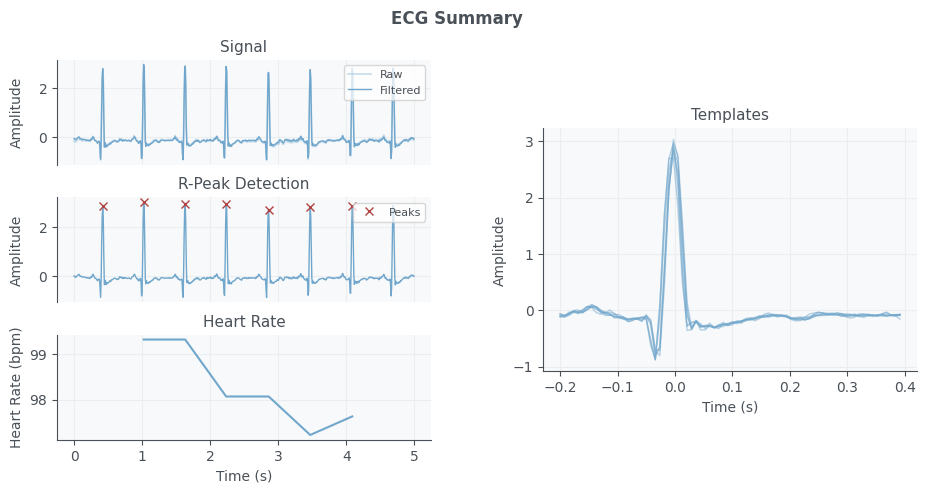

In [11]:
from biosppy.signals import ecg
out = ecg.ecg(signal=ECG_SIGNAL[0:win*fs], sampling_rate=fs, show=True)

In [12]:
print(out.keys())

['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


### R - Peaks

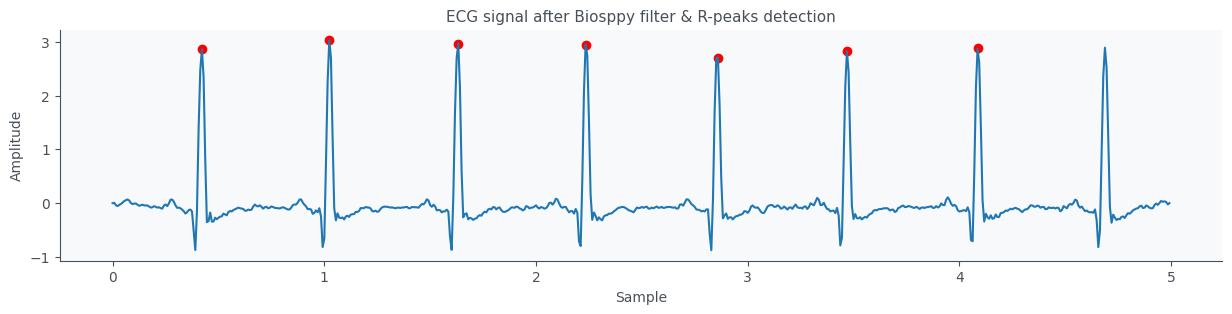

In [13]:
plt.figure(figsize=(15, 3))
plt.plot(out['ts'], out['filtered'])
plt.scatter(out['ts'][out['rpeaks']], out['filtered'][out['rpeaks']], color='red', label='R-peaks')
plt.title("ECG signal after Biosppy filter & R-peaks detection")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### Templates

Extracted pulse

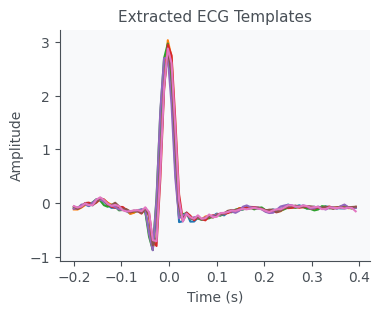

In [14]:
plt.figure(figsize=(4, 3))
for template in out['templates']:
	plt.plot(out['templates_ts'], template)
plt.title("Extracted ECG Templates")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### <b>Data Validating. </b>

In [15]:
signal_quality_now = []
win_intra = 1

for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
    min_limit = k - win_intra * fs
    max_limit = k
    window_complete_intra = filt[min_limit:max_limit]

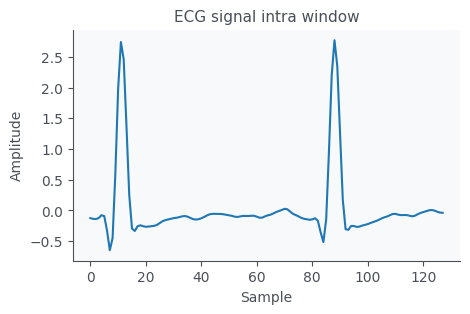

In [16]:
# plot the intra window
plt.figure(figsize=(5, 3))
plt.plot(window_complete_intra)
plt.title("ECG signal intra window")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


This class determines the quality of an ECG segment, usually lasting several seconds. It computes SQIs (Signal Quality Indicator) and use them in a pre-trained model to predict the quality:

        1 : good quality
        0 : bad quality


From an ECG segment signal, use pre-trained model to compute the quality of the signal. This method is a shortcut to using compute_sqi_scores then predict quality.

#### <b>compute sqi scores. </b>
From an ECG Signal segment, computes 6 SQI scores (q_sqi, c_sqi, s_sqi,k_sqi, p_sqi, bas_sqi)


In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Normalizing the signal
ecg_signal = StandardScaler().fit_transform(window_complete_intra.reshape(-1, 1)).reshape(1, -1)[0]

### 1.Variability in the R-R Interval

aims to quantify how much variability there is in the intervals between successive R-peaks (R-R intervals) detected in the ECG.High variability often indicates poor signal quality due to artifacts. 

In [19]:
import biosppy.signals.ecg as bsp_ecg

QRS detection method (bsp_ecg.hamilton_segmenter) to identify the R-peaks in the ECG signal. This method returns a list of detected R-R intervals (time intervals between consecutive R-peaks).

In [20]:
rri_list = bsp_ecg.hamilton_segmenter(
    signal=np.array(ecg_signal),
    sampling_rate=fs
)
print("R-R intervals:", rri_list)

R-R intervals: ReturnTuple(rpeaks=array([11, 88]))


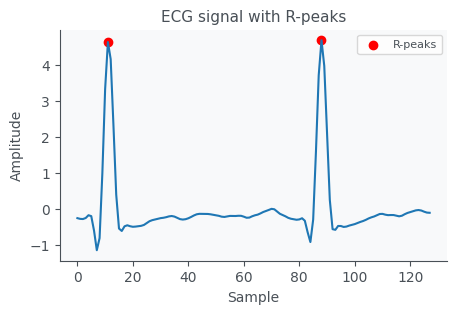

In [21]:
# plot the ecg signal and mark the R-peaks
plt.figure(figsize=(5, 3))
plt.plot(ecg_signal)
plt.scatter(rri_list, ecg_signal[rri_list], color='red', label='R-peaks')
plt.title("ECG signal with R-peaks")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

Calculates the coefficient of variation of these R-R intervals, computed as the standard deviation (with Bessel's correction, ddof=1) divided by the mean of the R-R intervals.

In [22]:
c_sqi_score = float(np.round(
    np.std(rri_list,ddof=1)/np.mean(rri_list),3
))
print("c_sqi_score:", c_sqi_score)

c_sqi_score: 1.1


#### Matching Degree of R Peak Detection

Two R wave detection algorithms are compared with their respective number of R waves detected.

    * Hamilton
    * SWT (Stationary Wavelet Transform)


In [23]:
from ecgdetectors import Detectors

To evaluate ECG signal quality by comparing the R-peak detections made by two separate algorithms:

    Hamilton detector: A classic R-peak detection method.
    SWT detector: Uses the Stationary Wavelet Transform for R-peak detection.

Their agreement on detected R-peaks serves as a signal quality index.

In [24]:
detectors = Detectors(fs)
qrs_frames_swt = detectors.swt_detector(ecg_signal)
qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
    signal = np.array(ecg_signal),
    sampling_rate = fs)

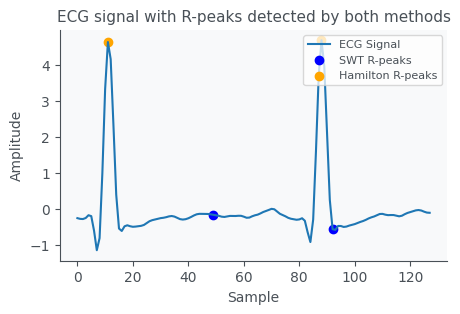

In [25]:
# plot the signal with R-peaks detected by both methods
plt.figure(figsize=(5, 3))
plt.plot(ecg_signal, label='ECG Signal')
plt.scatter(qrs_frames_swt, ecg_signal[qrs_frames_swt], color='blue', label='SWT R-peaks')
plt.scatter(qrs_frames_hamilton, ecg_signal[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
plt.title("ECG signal with R-peaks detected by both methods")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

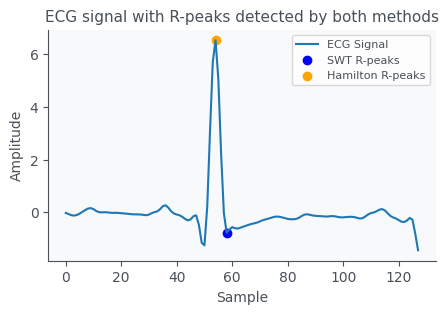

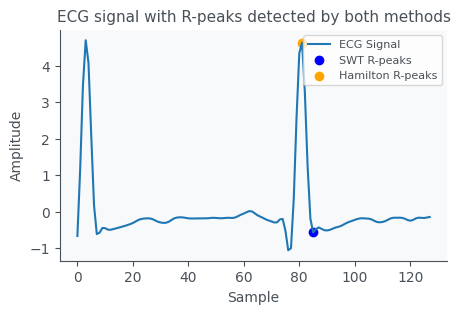

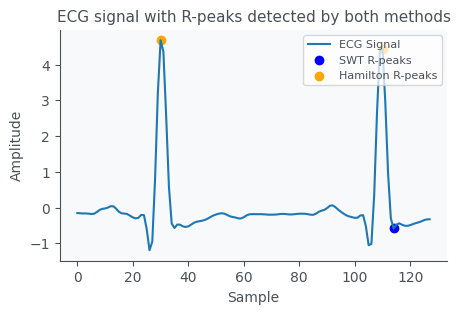

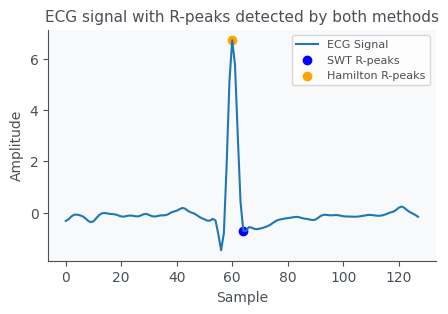

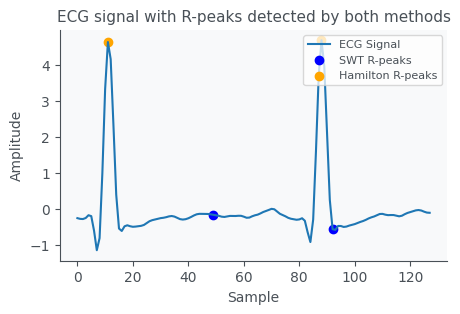

In [26]:
signal_quality_now = []
win_intra = 1

for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
    min_limit = k - win_intra * fs
    max_limit = k
    window_complete_intra = filt[min_limit:max_limit]
    # Normalizing the signal
    ecg_signal = StandardScaler().fit_transform(window_complete_intra.reshape(-1, 1)).reshape(1, -1)[0]

    detectors = Detectors(fs)
    qrs_frames_swt = detectors.swt_detector(ecg_signal)
    qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
        signal = np.array(ecg_signal),
        sampling_rate = fs)
    
    # plot the signal with R-peaks detected by both methods
    plt.figure(figsize=(5, 3))
    plt.plot(ecg_signal, label='ECG Signal')
    plt.scatter(qrs_frames_swt, ecg_signal[qrs_frames_swt], color='blue', label='SWT R-peaks')
    plt.scatter(qrs_frames_hamilton, ecg_signal[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
    plt.title("ECG signal with R-peaks detected by both methods")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()
    

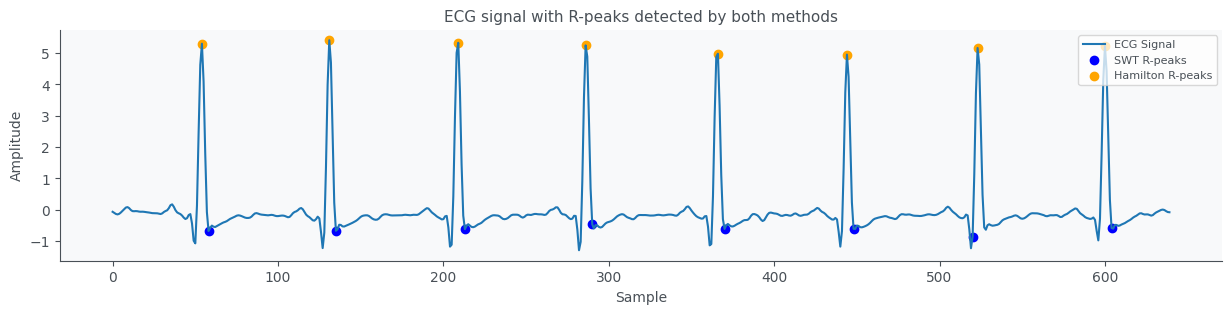

In [27]:
ecg_signal_full = StandardScaler().fit_transform(filt.reshape(-1, 1)).reshape(1, -1)[0]

detectors = Detectors(fs)
qrs_frames_swt = detectors.swt_detector(ecg_signal_full)
qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
    signal = np.array(ecg_signal_full),
    sampling_rate = fs)

# plot the signal with R-peaks detected by both methods
plt.figure(figsize=(15, 3))
plt.plot(ecg_signal_full, label='ECG Signal')
plt.scatter(qrs_frames_swt, ecg_signal_full[qrs_frames_swt], color='blue', label='SWT R-peaks')
plt.scatter(qrs_frames_hamilton, ecg_signal_full[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
plt.title("ECG signal with R-peaks detected by both methods")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

calculates a similarity score (correlation coefficient) between two lists of detected QRS frames (R-peak positions) from ECG signals. This score reflects how well two R-peak detection methods agree on the positions of detected beats.

In [28]:
detectors = Detectors(fs)
qrs_frames_swt = detectors.swt_detector(ecg_signal)
qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
    signal = np.array(ecg_signal),
    sampling_rate = fs)

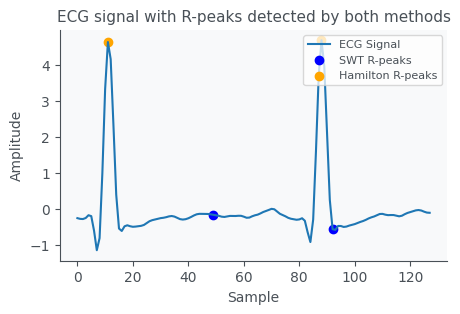

In [29]:
# plot the signal with R-peaks detected by both methods
plt.figure(figsize=(5, 3))
plt.plot(ecg_signal, label='ECG Signal')
plt.scatter(qrs_frames_swt, ecg_signal[qrs_frames_swt], color='blue', label='SWT R-peaks')
plt.scatter(qrs_frames_hamilton, ecg_signal[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
plt.title("ECG signal with R-peaks detected by both methods")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [30]:
print("Number of R-peaks detected by SWT:", len(qrs_frames_swt))
print("Number of R-peaks detected by Hamilton:", len(qrs_frames_hamilton))

print("R-peaks detected by SWT:", qrs_frames_swt)
print("R-peaks detected by Hamilton:", qrs_frames_hamilton)

Number of R-peaks detected by SWT: 2
Number of R-peaks detected by Hamilton: 1
R-peaks detected by SWT: [49, 92]
R-peaks detected by Hamilton: ReturnTuple(rpeaks=array([11, 88]))


In [31]:
print(type(qrs_frames_swt))
print(type(qrs_frames_hamilton))

<class 'list'>
<class 'biosppy.utils.ReturnTuple'>


In [32]:
qrs_frames_hamilton = np.array(qrs_frames_hamilton).reshape(-1, )

#### Frame_tolerance

1. Converts the tolerance from milliseconds to number of samples (frames).
2. matching_qrs_frames_tolerance is given in milliseconds (default 50 ms).
3. Multiply 50 ms by (0.001 / single_frame_duration) converts that time window into the equivalent number of frames.

So, two QRS detections within this number of frames are considered matching.

In [33]:
matching_qrs_frames_tolerance = 50
single_frame_duration = 1/fs

frame_tolerance =  matching_qrs_frames_tolerance * (
        0.001 / single_frame_duration)
print("Frame tolerance in frames:", frame_tolerance)

Frame tolerance in frames: 6.4


In [34]:
# Catch complete failed QRS detection
i=0
j=0
matching_frames = 0

while i < len(qrs_frames_hamilton) and j < len(qrs_frames_swt):
    min_qrs_frame = min(qrs_frames_hamilton[i],qrs_frames_swt[j])

    # Get missing detected beats intervals
    # Matching frames

    if abs(qrs_frames_swt[j] - qrs_frames_hamilton[i]) < frame_tolerance:
        matching_frames += 1
        i += 1
        j += 1
    else:
        # increment first QRS in frame list
        if min_qrs_frame == qrs_frames_hamilton[i]:
            i += 1
        else:
            j += 1
print("Matching frames:", matching_frames)

Matching frames: 1


In [35]:
correlation_coefs = 2 * matching_frames / (len(qrs_frames_hamilton) +
                                            len(qrs_frames_swt))

correlation_coefs = round(correlation_coefs, 3)
print("Correlation coefficients:", correlation_coefs)
q_sqi_score = correlation_coefs

Correlation coefficients: 0.5


### 2.Computes the skewness sqi.

Skewness represents how asymetrical a distribution is.

    * Symetrical distribution : skewness = 0
    * Asymetrical distribution skewed on the left : skewness < 0
    * Asymetrical distribution skewed on the right : skewness > 0



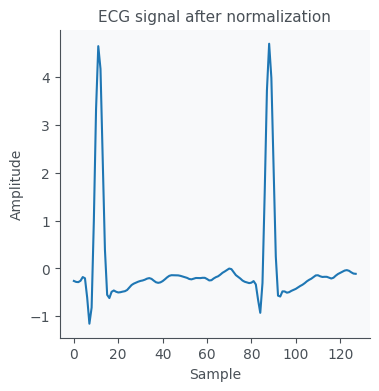

In [36]:
# plot the ecg signal after normalization
plt.figure(figsize=(4, 4))
plt.plot(ecg_signal)
plt.title("ECG signal after normalization")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Calculate the third central moment (cube of deviations from the mean)

In [37]:
num = np.mean((ecg_signal-np.mean(ecg_signal))**3)
num

np.float64(3.4938031543255192)

Calculate the standard deviation σ of the ECG signal with Bessel's correction (ddof=1)

In [38]:
s_sqi = num / (np.std(ecg_signal,ddof=1)**3)

Compute skewness, This normalizes the third moment by the cube of the standard deviation, giving a dimensionless measure of skewness.

In [39]:
s_sqi_score = float(np.round(s_sqi, 3))
print("s_sqi_score:", s_sqi_score)

s_sqi_score: 3.453


### 3.Computes the excess kurtosis sqi.

Kurtosis represents how spread a distribution is.

    * Mesokurtic distribution : excess kurtosis = 0
    * Leptokurtic distribution : excess kurtosis > 0
    * Platykurtic distribution : excess kurtosis < 0



Compute the fourth central moment of the ECG signa

In [40]:
num = np.mean((ecg_signal - np.mean(ecg_signal))**4)

Compute the standard deviation of the ECG signal with Bessel’s correction (ddof=1) & Calculate the kurtosis (normalized fourth central moment).

In [41]:
k_sqi = num / (np.std(ecg_signal, ddof=1)**4)

Convert kurtosis to excess kurtosis by subtracting 3

In [42]:
k_sqi_fischer = k_sqi - 3.0

The excess kurtosis value rounded to three decimal places 

In [43]:
k_sqi_score = float(round(k_sqi_fischer, 3))
print("k_sqi_score:", k_sqi_score)

k_sqi_score: 11.446


### 3.Computes the power spectrum Distribution of QRS Wave.

It corresponds to the ratio of the energy of the QRS wave and the energy of the ECG signal. The energy of the QRS wave is computed on frequencies ranging from 5Hz to 15Hz, the energy of the ECG signal is computed on frequencies ranging from 5Hz to 40Hz.

If interference exists, the high-frequency component increases, and pSQI decreases.

This ratio helps detect interference or noise: higher noise often increases energy in higher frequencies, thus decreasing the pSQI value.



In [44]:
n = len(ecg_signal)
t = 1/fs

<b> Fourier Transform</b>

yf is the complex Fast Fourier Transform (FFT) of the ECG signal. This transforms the time-domain signal into the frequency domain, showing how much component energy is present at each frequency.

In [45]:
yf = np.fft.fft(ecg_signal)

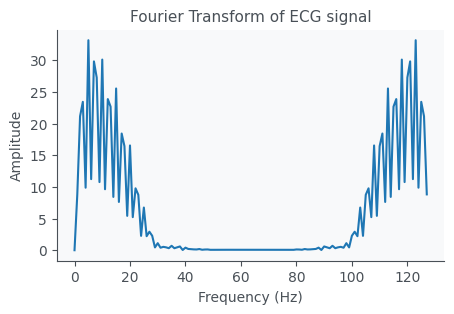

In [46]:
# plot the Fourier Transform
plt.figure(figsize=(5, 3))
plt.plot(np.abs(yf))
plt.title("Fourier Transform of ECG signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

xf is the array of corresponding frequency values from 0 Hz up to the Nyquist frequency (which is half the sampling rate).

In [47]:
xf = np.linspace(0.0, 1.0/(2.0*t), n//2)

<b>Energy Calculation</b>

collects the magnitudes (absolute values) of FFT components whose frequencies lie between 5 Hz and 15 Hz — this band typically contains the energy of the QRS complex.

In [48]:
pds_num = [np.abs(yf[idx]) for idx in range(len(xf)) if
               xf[idx] >= 5 and xf[idx] <= 15]
print("pds_num:", pds_num)

pds_num: [np.float64(33.15590043366878), np.float64(11.224375003499715), np.float64(29.81173044659189), np.float64(27.26393533569008), np.float64(10.75953198380063), np.float64(30.09868957137324), np.float64(9.629733825238509), np.float64(23.86364174664993), np.float64(22.66921137144666), np.float64(8.416998290239121)]


collects magnitudes of FFT components between 5 Hz and 40 Hz — a broader band that covers the main ECG frequencies including noise and other waveform components.

In [49]:
pds_denom = [np.abs(yf[idx]) for idx in range(len(xf)) if
                 xf[idx] >= 5 and xf[idx] <= 40]
print("pds_denom:", pds_denom)

pds_denom: [np.float64(33.15590043366878), np.float64(11.224375003499715), np.float64(29.81173044659189), np.float64(27.26393533569008), np.float64(10.75953198380063), np.float64(30.09868957137324), np.float64(9.629733825238509), np.float64(23.86364174664993), np.float64(22.66921137144666), np.float64(8.416998290239121), np.float64(25.535586219171794), np.float64(7.622205585690183), np.float64(18.423885104507995), np.float64(16.434458066439518), np.float64(5.4261115229990775), np.float64(16.541607676335275), np.float64(5.222047429165931), np.float64(9.773745200756277), np.float64(8.747918996630212), np.float64(2.2673687468417434), np.float64(6.738674520048478), np.float64(2.2145936337609324), np.float64(2.918741751261374), np.float64(2.2832510101933705), np.float64(0.44464527945510146), np.float64(1.1121124422852362), np.float64(0.39535181930460045), np.float64(0.5328447475878896), np.float64(0.45601786259528426), np.float64(0.3201374744226155), np.float64(0.6975687596174659), np.float

<b>pSQI Computation</b>

sums the magnitudes in the QRS band (pds_num) and divides by the summed magnitudes in the broader band (pds_denom), which yields a ratio representing the proportion of energy in the QRS frequency band relative to the total ECG signal energy in the 5-40 Hz band.

This ratio is rounded to 3 decimal places.

In [50]:
p_sqi_score = float(np.round(sum(pds_num) / sum(pds_denom), 3))
print("p_sqi_score:", p_sqi_score)

p_sqi_score: 0.604


### 4.Computes the relative power in the Baseline.

It corresponds to the ratio of the energy of the QRS wave and the energy of the ECG signal. The energy of the baseline is computed on frequencies ranging from 0Hz to 1Hz, the energy of the ECG signal is computed on frequencies ranging from 0Hz to 40Hz.

If there is no baseline drift interference, the basSQI value is close to 1. An abnormal shift in the baseline causes the bassqi to decrease.



In [51]:
n = len(ecg_signal)
t = 1 / fs

yf = np.fft.fft(ecg_signal)
xf = np.linspace(0.0, 1.0/(2.0*t), n//2)

pds_num = [np.abs(yf[idx]) for idx in range(len(xf)) if
            xf[idx] >= 0 and xf[idx] <= 1]
pds_denom = [np.abs(yf[idx]) for idx in range(len(xf)) if
                xf[idx] >= 0 and xf[idx] <= 40]

bas_sqi_score = float(np.round(1 - (sum(pds_num) / sum(pds_denom)), 3))
print("bas_sqi_score:", bas_sqi_score)

bas_sqi_score: 1.0


In [52]:
sqi_scores = [[q_sqi_score, c_sqi_score, s_sqi_score,
                       k_sqi_score, p_sqi_score, bas_sqi_score]]

In [53]:
# Print sqi_scores
print("SQI Scores:", sqi_scores)

SQI Scores: [[0.5, 1.1, 3.453, 11.446, 0.604, 1.0]]


 we use a decision tree classifier to evaluate the 
signal quality every second and calculate the mean value for the entire 
input sample with the aim of removing excessively noisy samples. 
Taking into account this signal quality score, we retain only those 
samples with a score of 0.5 or higher, that is, at least 50% of the 
signal conforms to the structure of a normal ECG.

In [54]:
from joblib import load

In [55]:
model_to_load = 'trained_models_quality_check/xgb_9s.joblib'

ml_model = load(model_to_load)

In [56]:
np.asarray(sqi_scores)

array([[ 0.5  ,  1.1  ,  3.453, 11.446,  0.604,  1.   ]])

In [57]:
ml_model

,objective,'binary:logistic'
,use_label_encoder,True
,base_score,0.5
,booster,'gbtree'
,colsample_bylevel,1
,colsample_bynode,1
,colsample_bytree,1
,gamma,0.2
,gpu_id,-1
,importance_type,'gain'
,interaction_constraints,''


In [58]:
sqi_scores = np.asarray(sqi_scores)
ml_model.predict(sqi_scores)

array([1])